In [17]:
import os
import torch
import collections
from PIL import Image
from torchvision import transforms
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from model import SSD300, MultiBoxLoss
from detect import *

Download image dataset and clone github repository

In [2]:
if not os.path.exists('open-images-bus-trucks'):
    !pip install -q torch_snippets
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz
    !git clone https://github.com/sizhky/ssd-utils/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.2/101.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 73.6 MB/s eta 0:00:00
Cloning i

In [3]:
%cd ssd-utils

/content/ssd-utils


Preprocess the data

In [4]:
from torch_snippets import *
DATA_ROOT = '../open-images-bus-trucks/'
IMAGE_ROOT = f'{DATA_ROOT}/images'
DF_RAW = df = pd.read_csv(f'{DATA_ROOT}/df.csv')

df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())]

label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Prepare data

In [9]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
denormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

In [14]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 300, 300
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
        logger.info(f'{len(self)} items loaded')

    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        return img, boxes, labels

    def collate_fn(self, batch):
        images, boxes, labels = [], [], []
        for item in batch:
            img, image_boxes, image_labels = item
            img = preprocess_image(img)[None]
            images.append(img)
            boxes.append(torch.tensor(image_boxes).float().to(device)/300.)
            labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
        images = torch.cat(images).to(device)
        return images, boxes, labels
    def __len__(self):
        return len(self.image_infos)

Prepare the training and test datasets and the dataloaders

In [15]:
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

[08/26/24 07:36:09] INFO     13702 items loaded                                                                                   ]8;id=860498;file://<ipython-input-14-697df6c2deb2>:8\<ipython-input-14-697df6c2deb2>]8;;\:]8;id=472061;file://<ipython-input-14-697df6c2deb2>:8#__init__:8\__init__:8]8;;\

                    INFO     1523 items loaded                                                                                    ]8;id=906317;file://<ipython-input-14-697df6c2deb2>:8\<ipython-input-14-697df6c2deb2>]8;;\:]8;id=128554;file://<ipython-input-14-697df6c2deb2>:8#__init__:8\__init__:8]8;;\

Functions to train on a batch of data and calculate the accuracy and loss value on the validation data

In [16]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    N = len(train_loader)
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

In [20]:
n_epochs = 3

model = SSD300(num_classes, device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)


Loaded base model.



Train the model over increasing epochs

In [23]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        train_loss = train_batch(inputs, model, criterion, optimizer)
        pos = (epoch + (ix+1)/_n)
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        test_loss = validate_batch(inputs, model, criterion)
        pos = (epoch + (ix+1)/_n)

    print(f"Epoch: {epoch + 1} Trainig Loss: {train_loss} Testing Loss: {test_loss}")

Epoch: 1 Trainig Loss: 2.922670841217041 Testing Loss: 2.478963613510132
Epoch: 2 Trainig Loss: 1.951627254486084 Testing Loss: 2.067289352416992
Epoch: 3 Trainig Loss: 1.3969428539276123 Testing Loss: 1.6202353239059448


In [24]:
image_paths = Glob(f'{DATA_ROOT}/images/*')
image_id = choose(test_ds.image_infos)
img_path = find(image_id, test_ds.files)
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

[[0, 0, 256, 205]] ['background @ 0.00']


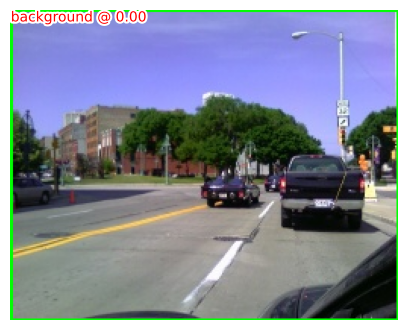

[[64, 46, 195, 138]] ['Truck @ 1.00']


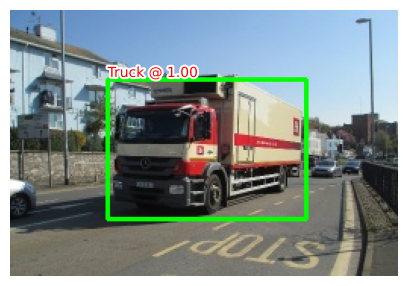

[[28, 21, 180, 152]] ['Truck @ 0.99']


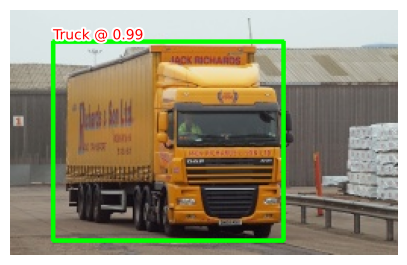

In [25]:
image_paths = Glob(f'{DATA_ROOT}/images/*')
for _ in range(3):
    image_id = choose(test_ds.image_infos)
    img_path = find(image_id, test_ds.files)
    original_image = Image.open(img_path, mode='r')
    bbs, labels, scores = detect(original_image, model, min_score=0.9, max_overlap=0.5,top_k=200, device=device)
    labels = [target2label[c.item()] for c in labels]
    label_with_conf = [f'{l} @ {s:.2f}' for l,s in zip(labels,scores)]
    print(bbs, label_with_conf)
    show(original_image, bbs=bbs, texts=label_with_conf, text_sz=10)